In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')
from sklearn.inspection import permutation_importance

# For neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Set plotting style
plt.style.use('ggplot')
sns.set(style='whitegrid')

# Load the dataset
def load_data(file_path):
    df = pd.read_csv(file_path, delimiter='\t')
    print(f"Dataset loaded with shape: {df.shape}")
    return df

In [ ]:
# Data preprocessing
def preprocess_data(df):
    # Make a copy to avoid modifying the original dataframe
    data = df.copy()

    # Drop unnecessary columns
    print("Original columns:", data.columns.tolist())

    # Convert callDateTime to datetime format
    data['callDateTime'] = pd.to_datetime(data['callDateTime'], errors='coerce')

    # Extract date and time features
    data['call_date'] = data['callDateTime'].dt.date
    data['call_hour'] = data['callDateTime'].dt.hour
    data['call_day'] = data['callDateTime'].dt.day_of_week
    data['call_month'] = data['callDateTime'].dt.month
    data['is_weekend'] = data['call_day'].apply(lambda x: 1 if x >= 5 else 0)  # 5,6 represent weekend (Sat, Sun)

    # Create the target variable (1 for fake call, 0 for real call)
    data['is_fake'] = data['priority'].apply(lambda x: 1 if x in ['Low', 'Non-Emergency'] else 0)

    # Print unique priority values to verify our categorization
    print("\nUnique priority values:", data['priority'].unique())
    print("\nTarget variable distribution:")
    print(data['is_fake'].value_counts())

    return data


In [ ]:
# Exploratory Data Analysis
def explore_data(data):
    # Display basic information
    print("\n--- Basic Information ---")
    print(data.info())

    # Descriptive statistics
    print("\n--- Descriptive Statistics ---")
    print(data.describe())

    # Check for missing values
    print("\n--- Missing Values ---")
    missing_values = data.isnull().sum()
    print(missing_values[missing_values > 0])

    # Print first few rows
    print("\n--- Sample Data ---")
    print(data.head())

    return data

In [ ]:
# Visualize data
def visualize_data(data):
    print("\n--- Data Visualization ---")

    # Set up the visualization area
    plt.figure(figsize=(20, 15))

    # Plot 1: Distribution of fake vs. real calls
    plt.subplot(2, 3, 1)
    sns.countplot(x='is_fake', data=data)
    plt.title('Distribution of Fake vs. Real Calls')
    plt.xlabel('Is Fake (1=Yes, 0=No)')
    plt.ylabel('Count')

    # Plot 2: Distribution of priorities
    plt.subplot(2, 3, 2)
    sns.countplot(y='priority', data=data, order=data['priority'].value_counts().index)
    plt.title('Distribution of Call Priorities')
    plt.xlabel('Count')
    plt.ylabel('Priority')

    # Plot 3: Call distribution by hour
    plt.subplot(2, 3, 3)
    sns.countplot(x='call_hour', data=data, hue='is_fake')
    plt.title('Call Distribution by Hour (Fake vs. Real)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Count')
    plt.legend(title='Is Fake')

    # Plot 4: Call distribution by day of week
    plt.subplot(2, 3, 4)
    day_of_week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    data['day_name'] = data['call_day'].map(day_of_week)
    sns.countplot(x='day_name', data=data, hue='is_fake',
                  order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.title('Call Distribution by Day of Week (Fake vs. Real)')
    plt.xlabel('Day of Week')
    plt.ylabel('Count')
    plt.legend(title='Is Fake')

    # Plot 5: Top 10 descriptions for fake calls
    plt.subplot(2, 3, 5)
    fake_calls = data[data['is_fake'] == 1]
    top_fake_desc = fake_calls['description'].value_counts().head(10)
    sns.barplot(y=top_fake_desc.index, x=top_fake_desc.values)
    plt.title('Top 10 Descriptions for Fake Calls')
    plt.xlabel('Count')
    plt.ylabel('Description')

    # Plot 6: Top 10 descriptions for real calls
    plt.subplot(2, 3, 6)
    real_calls = data[data['is_fake'] == 0]
    top_real_desc = real_calls['description'].value_counts().head(10)
    sns.barplot(y=top_real_desc.index, x=top_real_desc.values)
    plt.title('Top 10 Descriptions for Real Calls')
    plt.xlabel('Count')
    plt.ylabel('Description')

    plt.tight_layout()
    plt.savefig('call_visualization.png')
    plt.show()

    # Additional visualizations
    plt.figure(figsize=(20, 10))

    # Plot 7: Distribution of fake vs. real calls by district
    plt.subplot(2, 2, 1)
    district_fake = pd.crosstab(data['district'], data['is_fake'])
    district_fake_pct = district_fake.div(district_fake.sum(axis=1), axis=0)
    district_fake_pct.plot(kind='bar', stacked=False, ax=plt.gca())
    plt.title('Percentage of Fake Calls by District')
    plt.xlabel('District')
    plt.ylabel('Percentage')
    plt.legend(title='Is Fake')

    # Plot 8: Distribution of fake vs. real calls by police district
    plt.subplot(2, 2, 2)
    pd_fake = pd.crosstab(data['PoliceDistrict'], data['is_fake'])
    pd_fake_pct = pd_fake.div(pd_fake.sum(axis=1), axis=0)
    pd_fake_pct.plot(kind='bar', stacked=False, ax=plt.gca())
    plt.title('Percentage of Fake Calls by Police District')
    plt.xlabel('Police District')
    plt.ylabel('Percentage')
    plt.legend(title='Is Fake')

    # Plot 9: Distribution of call types
    plt.subplot(2, 2, 3)
    top_descriptions = data['description'].value_counts().head(15)
    sns.barplot(y=top_descriptions.index, x=top_descriptions.values)
    plt.title('Top 15 Call Descriptions')
    plt.xlabel('Count')
    plt.ylabel('Description')

    # Plot 10: Month-wise distribution
    plt.subplot(2, 2, 4)
    sns.countplot(x='call_month', data=data, hue='is_fake')
    plt.title('Call Distribution by Month (Fake vs. Real)')
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.legend(title='Is Fake')

    plt.tight_layout()
    plt.savefig('additional_visualization.png')
    plt.show()

    return data

In [ ]:
# Feature engineering for traditional ML models
def engineer_features(data):
    print("\n--- Feature Engineering ---")

    # Create a copy to avoid modifying the original dataframe
    df_fe = data.copy()

    # Create categorical features from description using TF-IDF
    print("Creating TF-IDF features from description...")
    # Fill NaN values in description with an empty string
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    description_features = tfidf.fit_transform(df_fe['description'].fillna('MISSING_DESCRIPTION'))

    # Store vectorizer as global variable for later interpretation
    global global_tfidf_vectorizer
    global_tfidf_vectorizer = tfidf

    # Convert to DataFrame and concatenate
    description_df = pd.DataFrame(description_features.toarray(),
                                 columns=[f'desc_{i}' for i in range(description_features.shape[1])])

    # Handle missing values in district and police district before one-hot encoding
    df_fe['district'] = df_fe['district'].fillna('UNKNOWN_DISTRICT')
    df_fe['PoliceDistrict'] = df_fe['PoliceDistrict'].fillna('UNKNOWN_PD')

    # Get one-hot encoding of district
    district_dummies = pd.get_dummies(df_fe['district'], prefix='district')

    # Get one-hot encoding of police district
    pd_dummies = pd.get_dummies(df_fe['PoliceDistrict'], prefix='pd')

    # Fill missing values in numerical features
    numerical_features = df_fe[['call_hour', 'call_day', 'call_month', 'is_weekend']].fillna(-1)

    # Combine all features
    combined_features = pd.concat([
        numerical_features,
        district_dummies,
        pd_dummies,
        description_df
    ], axis=1)

    print(f"Feature engineering completed. Feature shape: {combined_features.shape}")

    # Check for any remaining NaN values
    nan_check = combined_features.isnull().sum().sum()
    if nan_check > 0:
        print(f"WARNING: {nan_check} NaN values still present after feature engineering")
        print("Columns with NaN values:")
        print(combined_features.columns[combined_features.isnull().any()].tolist())
        # Apply a final imputation to any remaining NaN values
        combined_features = combined_features.fillna(-999)
    else:
        print("No NaN values present in features - data is ready for modeling")

    return combined_features, df_fe['is_fake'], df_fe


In [ ]:
# Train-test split function
def split_data(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,
                                                        random_state=random_state,
                                                        stratify=y)
    print(f"Training set shape: {X_train.shape}")
    print(f"Testing set shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test


In [ ]:
def train_decision_tree(X_train, X_test, y_train, y_test, random_state=42):
    print("\n--- Training Decision Tree Model ---")

    # Create and train the model
    dt_model = DecisionTreeClassifier(random_state=random_state, max_depth=5)
    dt_model.fit(X_train, y_train)

    # Make predictions
    y_pred = dt_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print results
    print(f"Decision Tree Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real Call', 'Fake Call'],
                yticklabels=['Real Call', 'Fake Call'])
    plt.title('Confusion Matrix - Decision Tree')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_decision_tree.png')
    plt.show()

    # Visualize the decision tree (limited depth for visibility)
    plt.figure(figsize=(20, 10))
    plot_tree(dt_model, max_depth=3, feature_names=X_train.columns,
               class_names=['Real Call', 'Fake Call'], filled=True)
    plt.title('Decision Tree for 911 Fake Call Detection')
    plt.savefig('decision_tree_visualization.png')
    plt.show()

    # Return model and results
    return {
        'model': dt_model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }


In [ ]:
# Artificial Neural Network (ANN) model training function
def train_ann(X_train, X_test, y_train, y_test):
    print("\n--- Training Artificial Neural Network (ANN) Model ---")

    # Scale features for neural network
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Build the model
    model = Sequential([
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    # Set up early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)
    y_pred = (model.predict(X_test_scaled) > 0.5).astype(int).flatten()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"ANN Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real Call', 'Fake Call'],
                yticklabels=['Real Call', 'Fake Call'])
    plt.title('Confusion Matrix - ANN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_ann.png')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig('ann_training_history.png')
    plt.show()

    # Return model and results
    return {
        'model': model,
        'scaler': scaler,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }


In [ ]:
# Recurrent Neural Network (RNN) model training function for text data
def train_rnn(data, max_words=10000, max_len=100):
    print("\n--- Training Recurrent Neural Network (RNN) Model for Text Analysis ---")

    # Prepare text data - using the description field
    descriptions = data['description'].fillna('MISSING_DESCRIPTION').values
    labels = data['is_fake'].values

    # Tokenize the text
    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(descriptions)

    # Convert text to sequences of tokens
    sequences = tokenizer.texts_to_sequences(descriptions)

    # Pad sequences to ensure uniform length
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    # Split the data
    indices = np.arange(padded_sequences.shape[0])
    np.random.shuffle(indices)
    padded_sequences = padded_sequences[indices]
    labels = labels[indices]

    # Determine split point (80% train, 20% test)
    split_idx = int(0.8 * len(padded_sequences))

    X_train, X_test = padded_sequences[:split_idx], padded_sequences[split_idx:]
    y_train, y_test = labels[:split_idx], labels[split_idx:]

    # Build RNN model (Bidirectional LSTM)
    model = Sequential([
        Embedding(max_words, 128, input_length=max_len),
        Bidirectional(LSTM(64, return_sequences=True)),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    # Define early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=15,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=1
    )

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\nRNN Results (Text-based):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real Call', 'Fake Call'],
                yticklabels=['Real Call', 'Fake Call'])
    plt.title('Confusion Matrix - RNN')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_rnn.png')
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('RNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('RNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.savefig('rnn_training_history.png')
    plt.show()

    # Return model and results
    return {
        'model': model,
        'tokenizer': tokenizer,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred,
        'X_test': X_test,
        'y_test': y_test
    }

In [ ]:
# Build and train models with improved handling of missing values
def build_models(X_train, X_test, y_train, y_test, raw_data=None, models_to_train=None):
    print("\n--- Building Models ---")

    # Set default models to train if not specified
    if models_to_train is None:
        models_to_train = ['rf', 'gb', 'lr', 'dt', 'ann']  # Default: all except RNN

    # Dictionary to store models and their performances
    model_results = {}

    # Train Random Forest if requested
    if 'rf' in models_to_train:
        print("\nTraining Random Forest...")
        rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        model_results['Random Forest'] = {
            'model': rf_model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred
        }

        # Print results
        print(f"Random Forest Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real Call', 'Fake Call'],
                    yticklabels=['Real Call', 'Fake Call'])
        plt.title('Confusion Matrix - Random Forest')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix_random_forest.png')
        plt.show()

    # Train Gradient Boosting if requested
    if 'gb' in models_to_train:
        print("\nTraining Gradient Boosting...")
        gb_model = HistGradientBoostingClassifier(random_state=42)
        gb_model.fit(X_train, y_train)
        y_pred = gb_model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        model_results['Gradient Boosting'] = {
            'model': gb_model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred
        }

        # Print results
        print(f"Gradient Boosting Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real Call', 'Fake Call'],
                    yticklabels=['Real Call', 'Fake Call'])
        plt.title('Confusion Matrix - Gradient Boosting')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix_gradient_boosting.png')
        plt.show()

    # Train Logistic Regression if requested
    if 'lr' in models_to_train:
        print("\nTraining Logistic Regression...")
        lr_model = LogisticRegression(random_state=42, max_iter=500)
        lr_model.fit(X_train, y_train)
        y_pred = lr_model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Store results
        model_results['Logistic Regression'] = {
            'model': lr_model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'predictions': y_pred
        }

        # Print results
        print(f"Logistic Regression Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['Real Call', 'Fake Call'],
                    yticklabels=['Real Call', 'Fake Call'])
        plt.title('Confusion Matrix - Logistic Regression')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix_logistic_regression.png')
        plt.show()

    # Train Decision Tree if requested
    if 'dt' in models_to_train:
        dt_results = train_decision_tree(X_train, X_test, y_train, y_test)
        model_results['Decision Tree'] = dt_results

    # Train ANN if requested
    if 'ann' in models_to_train:
        ann_results = train_ann(X_train, X_test, y_train, y_test)
        model_results['ANN'] = ann_results

    # Train RNN if requested (requires raw text data)
    if 'rnn' in models_to_train and raw_data is not None:
        rnn_results = train_rnn(raw_data)
        model_results['RNN'] = rnn_results

    return model_results

In [ ]:
# OPTIMIZATION: Changed from GridSearchCV to RandomizedSearchCV with fewer iterations
def tune_model(X_train, y_train, best_model_name):
    print(f"\n--- Quick Tuning for {best_model_name} Model ---")

    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42, n_jobs=-1)
        param_distributions = {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5]
        }
    elif best_model_name == 'Gradient Boosting':
        model = HistGradientBoostingClassifier(random_state=42)
        param_distributions = {
            'max_iter': [50, 100, 200],
            'learning_rate': [0.05, 0.1, 0.2],
            'max_depth': [3, 5, None]
        }
    elif best_model_name == 'Decision Tree':
        model = DecisionTreeClassifier(random_state=42)
        param_distributions = {
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['gini', 'entropy']
        }
    else:  # Logistic Regression
        model = LogisticRegression(random_state=42, max_iter=1000)
        param_distributions = {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'newton-cg']
        }

    # Create RandomizedSearchCV with fewer iterations and fewer CV folds
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=10,  # Only try 10 combinations instead of all possible combinations
        cv=3,       # Use 3-fold CV instead of 5-fold
        scoring='f1',
        n_jobs=-1,  # Use all available cores
        verbose=1,
        random_state=42
    )

    # Fit RandomizedSearchCV
    print("Starting hyperparameter tuning (this will be much faster)...")
    random_search.fit(X_train, y_train)

    # Print best parameters
    print("Best Parameters:", random_search.best_params_)
    print("Best F1 Score:", random_search.best_score_)

    return random_search.best_estimator_


In [ ]:
# Improved function to get feature importance
def get_feature_importance(model, X, y, random_state=42):
    """
    Get feature importance for any model, falling back to permutation importance
    when built-in importance is not available
    """
    feature_importance = None

    # Try standard feature_importances_ (for tree-based models like RandomForest)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})

    # Try coef_ for linear models like LogisticRegression
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})

    # If HistGradientBoostingClassifier, we can try to use its built-in method if available
    elif hasattr(model, '_compute_feature_importances'):
        try:
            importances = model._compute_feature_importances()
            feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})
            print("Using built-in feature importance method")
        except:
            print("Built-in feature importance failed, falling back to permutation importance")
            # Permutation importance will be used below

    # For neural networks and other models without direct feature importance
    elif hasattr(model, 'predict'):
        # Fallback to permutation importance for any model that has predict method
        print("Using permutation importance (this may take a moment)...")
        perm_importance = permutation_importance(model, X, y, n_repeats=5, random_state=random_state)
        importances = perm_importance.importances_mean
        feature_importance = pd.DataFrame({'feature': X.columns, 'importance': importances})

    else:
        print("Cannot determine feature importance for this model type")
        return None

    # Sort by importance
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    return feature_importance

In [ ]:
# Visualize feature importance
def visualize_feature_importance(feature_importance, model_name, top_n=20):
    if feature_importance is None:
        print("Feature importance not available for this model.")
        return

    # Plot the top N most important features
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
    plt.title(f'Top {top_n} Features - {model_name}')
    plt.tight_layout()
    plt.savefig(f'feature_importance_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

In [ ]:
# Evaluate model performance
def evaluate_final_model(model, X_test, y_test):
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print results
    print("\n--- Final Model Evaluation ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real Call', 'Fake Call'],
                yticklabels=['Real Call', 'Fake Call'])
    plt.title('Confusion Matrix - Final Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('confusion_matrix_final_model.png')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'predictions': y_pred
    }

In [ ]:
# Interpret TF-IDF features to understand what words they represent
def interpret_tfidf_features(data):
    # Refit a TF-IDF vectorizer with the same parameters
    tfidf = TfidfVectorizer(max_features=100, stop_words='english')
    tfidf.fit(data['description'].fillna('MISSING_DESCRIPTION'))

    # Create the reverse mapping
    vocab = tfidf.vocabulary_
    reverse_vocab = {v: k for k, v in vocab.items()}

    # Print out important features
    print("Feature desc_22 represents:", reverse_vocab.get(22, "Unknown term"))
    print("Feature desc_48 represents:", reverse_vocab.get(48, "Unknown term"))
    print("Feature desc_30 represents:", reverse_vocab.get(30, "Unknown term"))
    print("Feature desc_10 represents:", reverse_vocab.get(10, "Unknown term"))
    print("Feature desc_5 represents:", reverse_vocab.get(5, "Unknown term"))

    return reverse_vocab

In [ ]:
# Function to analyze patterns in fake calls
def analyze_fake_call_patterns(data):
    print("\n--- Analyzing Patterns in Fake Calls ---")

    # Filter to get only fake calls (Low or Non-Emergency priority)
    fake_calls = data[data['priority'].isin(['Low', 'Non-Emergency'])]
    print(f"Number of fake calls: {len(fake_calls)}")

    # Analyze descriptions
    print("\n1. Most Common Descriptions for Fake Calls:")
    desc_counts = fake_calls['description'].value_counts().head(15)
    print(desc_counts)

    plt.figure(figsize=(12, 8))
    sns.barplot(y=desc_counts.index, x=desc_counts.values)
    plt.title('Most Common Descriptions for Fake/Low Priority Calls')
    plt.xlabel('Count')
    plt.ylabel('Description')
    plt.tight_layout()
    plt.savefig('fake_call_descriptions.png')
    plt.show()

    # Analyze time patterns
    print("\n2. Time Patterns for Fake Calls:")
    plt.figure(figsize=(18, 10))

    plt.subplot(2, 2, 1)
    hourly_counts = fake_calls['call_hour'].value_counts().sort_index()
    sns.barplot(x=hourly_counts.index, y=hourly_counts.values)
    plt.title('Fake Calls by Hour of Day')
    plt.xlabel('Hour')
    plt.ylabel('Count')

    plt.subplot(2, 2, 2)
    day_of_week = {0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'}
    fake_calls['day_name'] = fake_calls['call_day'].map(day_of_week)
    day_counts = fake_calls['day_name'].value_counts()
    sns.barplot(x=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
                y=[day_counts.get(day, 0) for day in ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']])
    plt.title('Fake Calls by Day of Week')
    plt.xlabel('Day')
    plt.ylabel('Count')

    plt.subplot(2, 2, 3)
    month_counts = fake_calls['call_month'].value_counts().sort_index()
    sns.barplot(x=month_counts.index, y=month_counts.values)
    plt.title('Fake Calls by Month')
    plt.xlabel('Month')
    plt.ylabel('Count')

    plt.subplot(2, 2, 4)
    # Create a heatmap of fake calls by hour and day
    hour_day_pivot = pd.crosstab(fake_calls['call_hour'], fake_calls['day_name'])
    hour_day_pivot = hour_day_pivot[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]  # Reorder columns
    sns.heatmap(hour_day_pivot, cmap="YlGnBu", annot=False, fmt='d')
    plt.title('Heatmap of Fake Calls by Hour and Day')
    plt.xlabel('Day of Week')
    plt.ylabel('Hour of Day')

    plt.tight_layout()
    plt.savefig('fake_call_time_patterns.png')
    plt.show()

    # Analyze location patterns
    print("\n3. Location Patterns for Fake Calls:")
    plt.figure(figsize=(20, 12))

    plt.subplot(2, 2, 1)
    district_counts = fake_calls['district'].value_counts().head(10)
    sns.barplot(y=district_counts.index, x=district_counts.values)
    plt.title('Top 10 Districts for Fake Calls')
    plt.xlabel('Count')
    plt.ylabel('District')

    plt.subplot(2, 2, 2)
    neighborhood_counts = fake_calls['Neighborhood'].value_counts().head(15)
    sns.barplot(y=neighborhood_counts.index, x=neighborhood_counts.values)
    plt.title('Top 15 Neighborhoods for Fake Calls')
    plt.xlabel('Count')
    plt.ylabel('Neighborhood')

    plt.subplot(2, 2, 3)
    pd_counts = fake_calls['PoliceDistrict'].value_counts().head(10)
    sns.barplot(y=pd_counts.index, x=pd_counts.values)
    plt.title('Top 10 Police Districts for Fake Calls')
    plt.xlabel('Count')
    plt.ylabel('Police District')

    plt.subplot(2, 2, 4)
    # Description by District Heatmap
    desc_district = pd.crosstab(fake_calls['description'], fake_calls['district'])
    # Select top 10 descriptions and top 8 districts
    top_descs = fake_calls['description'].value_counts().head(10).index
    top_districts = fake_calls['district'].value_counts().head(8).index
    desc_district_subset = desc_district.loc[top_descs, top_districts]

    sns.heatmap(desc_district_subset, cmap="YlGnBu", annot=False)
    plt.title('Heatmap of Top Descriptions by District')
    plt.xlabel('District')
    plt.ylabel('Description')

    plt.tight_layout()
    plt.savefig('fake_call_location_patterns.png')
    plt.show()

    # Print final insights
    print("\n6. Key Patterns in Fake Calls:")
    print(f"a. Most common fake call description: {fake_calls['description'].value_counts().index[0]}")
    print(f"b. Peak hour for fake calls: {fake_calls['call_hour'].value_counts().index[0]}")
    print(f"c. Peak day for fake calls: {fake_calls['day_name'].value_counts().index[0]}")
    print(f"d. Most common location for fake calls: {fake_calls['Neighborhood'].value_counts().index[0]}")

    return fake_calls


In [ ]:
models_to_train=['rf', 'gb', 'lr', 'dt', 'ann']
print(f"Running with models: {models_to_train}")

Running with models: ['rf', 'gb', 'lr', 'dt', 'ann']


In [ ]:
# Load data
file_path = '911_Calls_for_Service csv_1.csv'
df = load_data(file_path)

Dataset loaded with shape: (113527, 20)


In [ ]:
# Preprocess data
data = preprocess_data(df)

Original columns: ['recordId', 'callKey', 'callDateTime', 'priority', 'district', 'description', 'callNumber', 'incidentLocation', 'location', 'Neighborhood', 'PoliceDistrict', 'PolicePost', 'CouncilDistrict', 'SheriffDistricts', 'Community_Statistical_Areas', 'Census_Tracts', 'ZIPCode', 'NeedsSync', 'ESRI_OID', ',,,']

Unique priority values: ['Low' 'Medium' 'Non-Emergency' 'High' 'Out of Service' nan 'Emergency'
 '212']

Target variable distribution:
is_fake
1    93079
0    20448
Name: count, dtype: int64


In [ ]:
# Explore data
data = explore_data(data)


--- Basic Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113527 entries, 0 to 113526
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   recordId                     113527 non-null  object             
 1   callKey                      113441 non-null  object             
 2   callDateTime                 113440 non-null  datetime64[ns, UTC]
 3   priority                     113441 non-null  object             
 4   district                     113441 non-null  object             
 5   description                  113441 non-null  object             
 6   callNumber                   113441 non-null  object             
 7   incidentLocation             113441 non-null  object             
 8   location                     113441 non-null  object             
 9   Neighborhood                 112770 non-null  object             
 10  Polic


--- Data Visualization ---


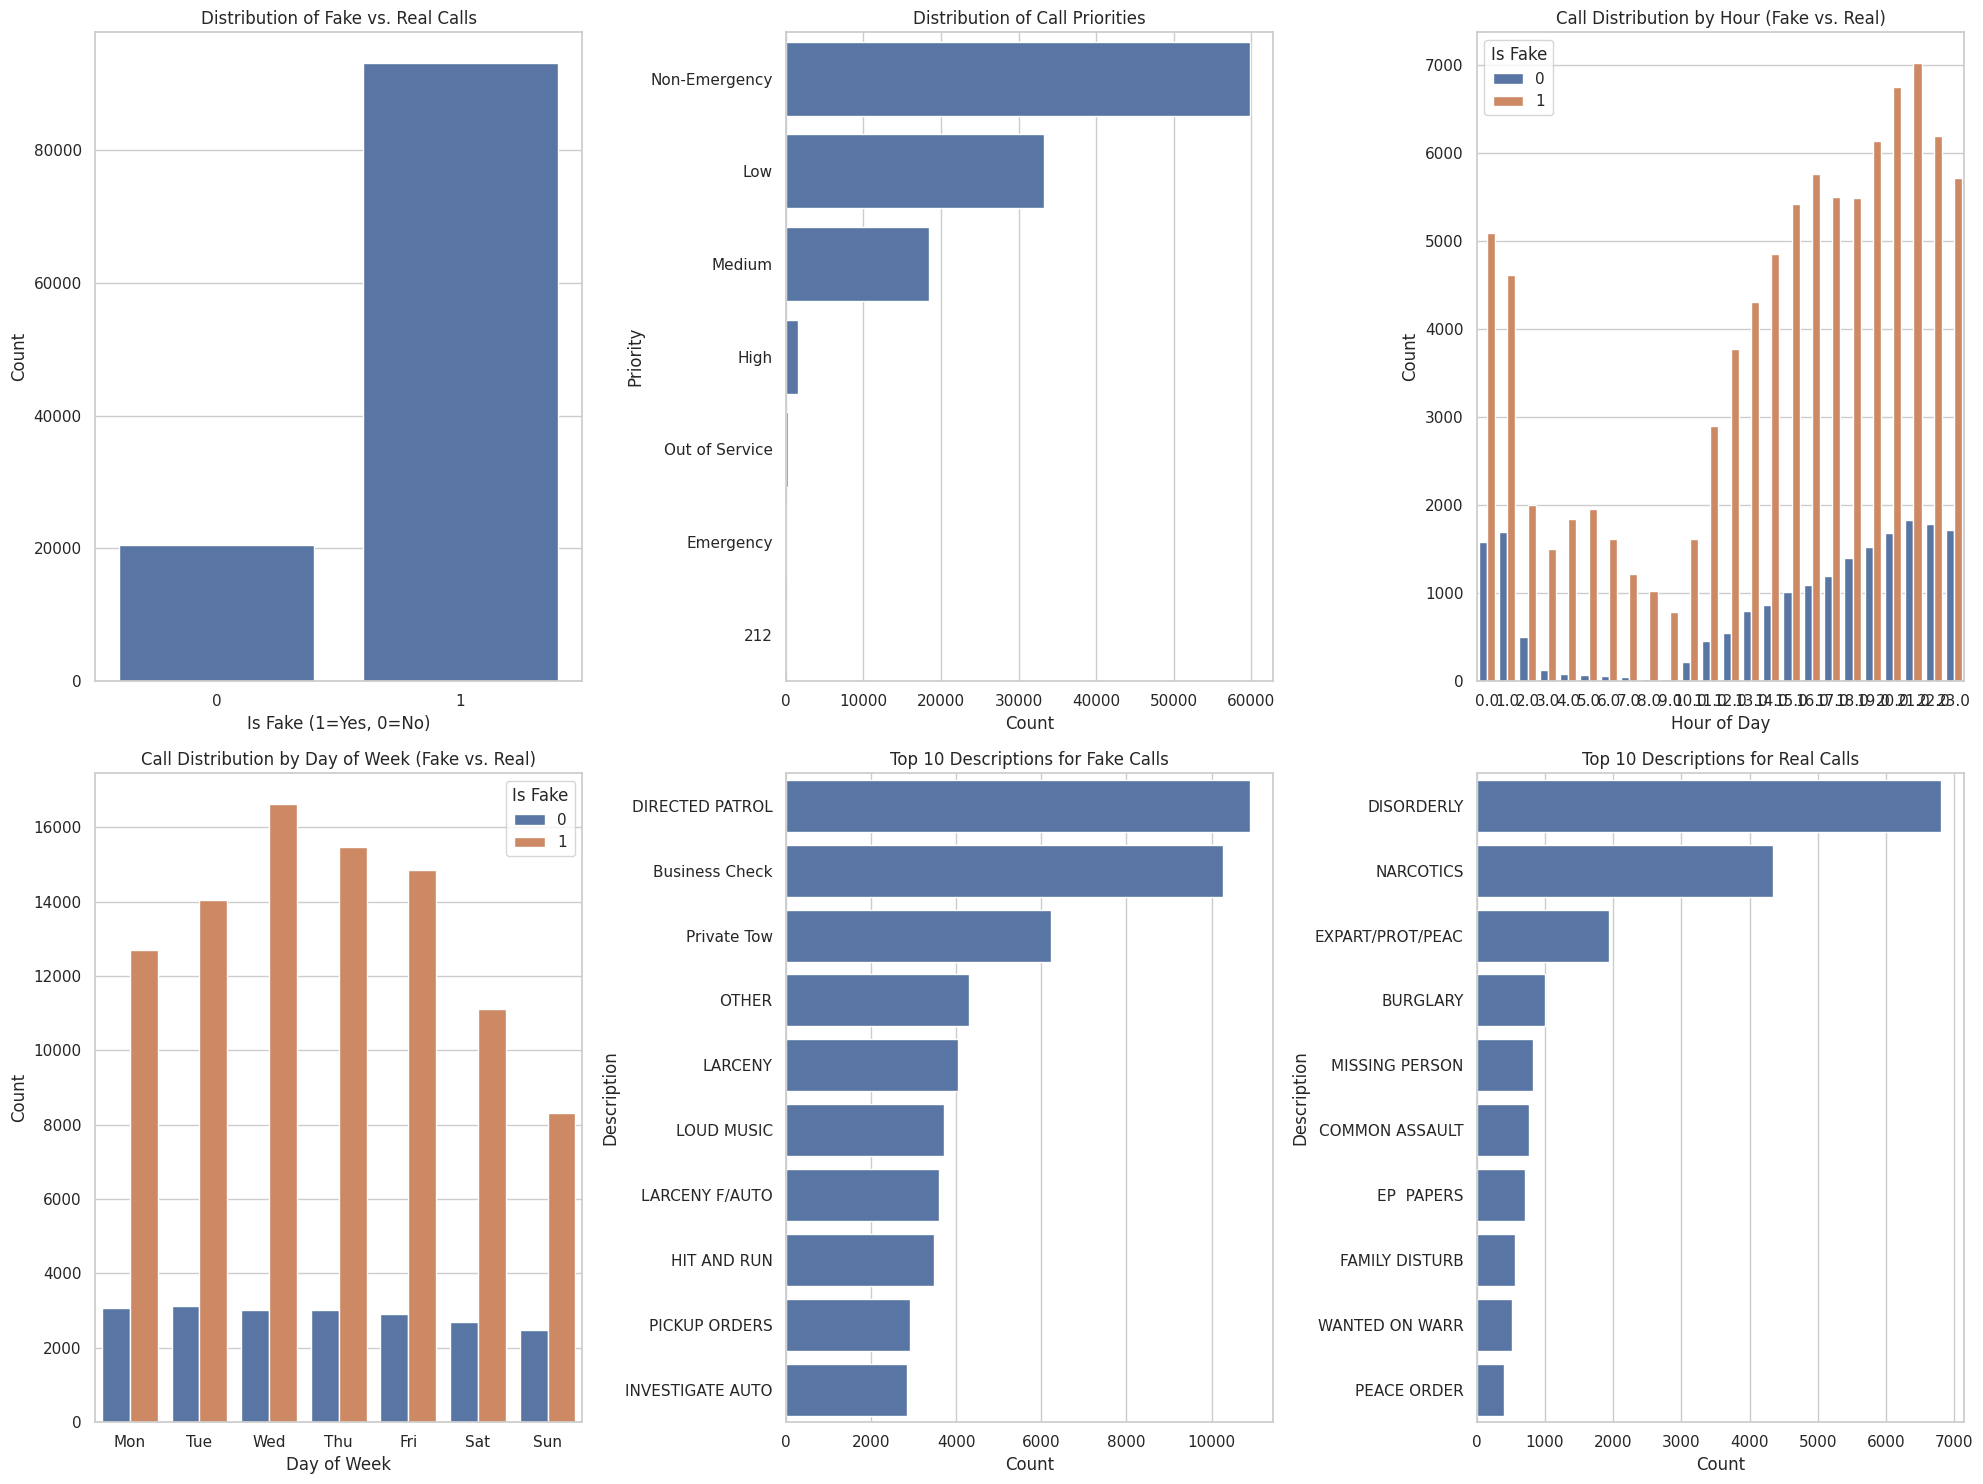

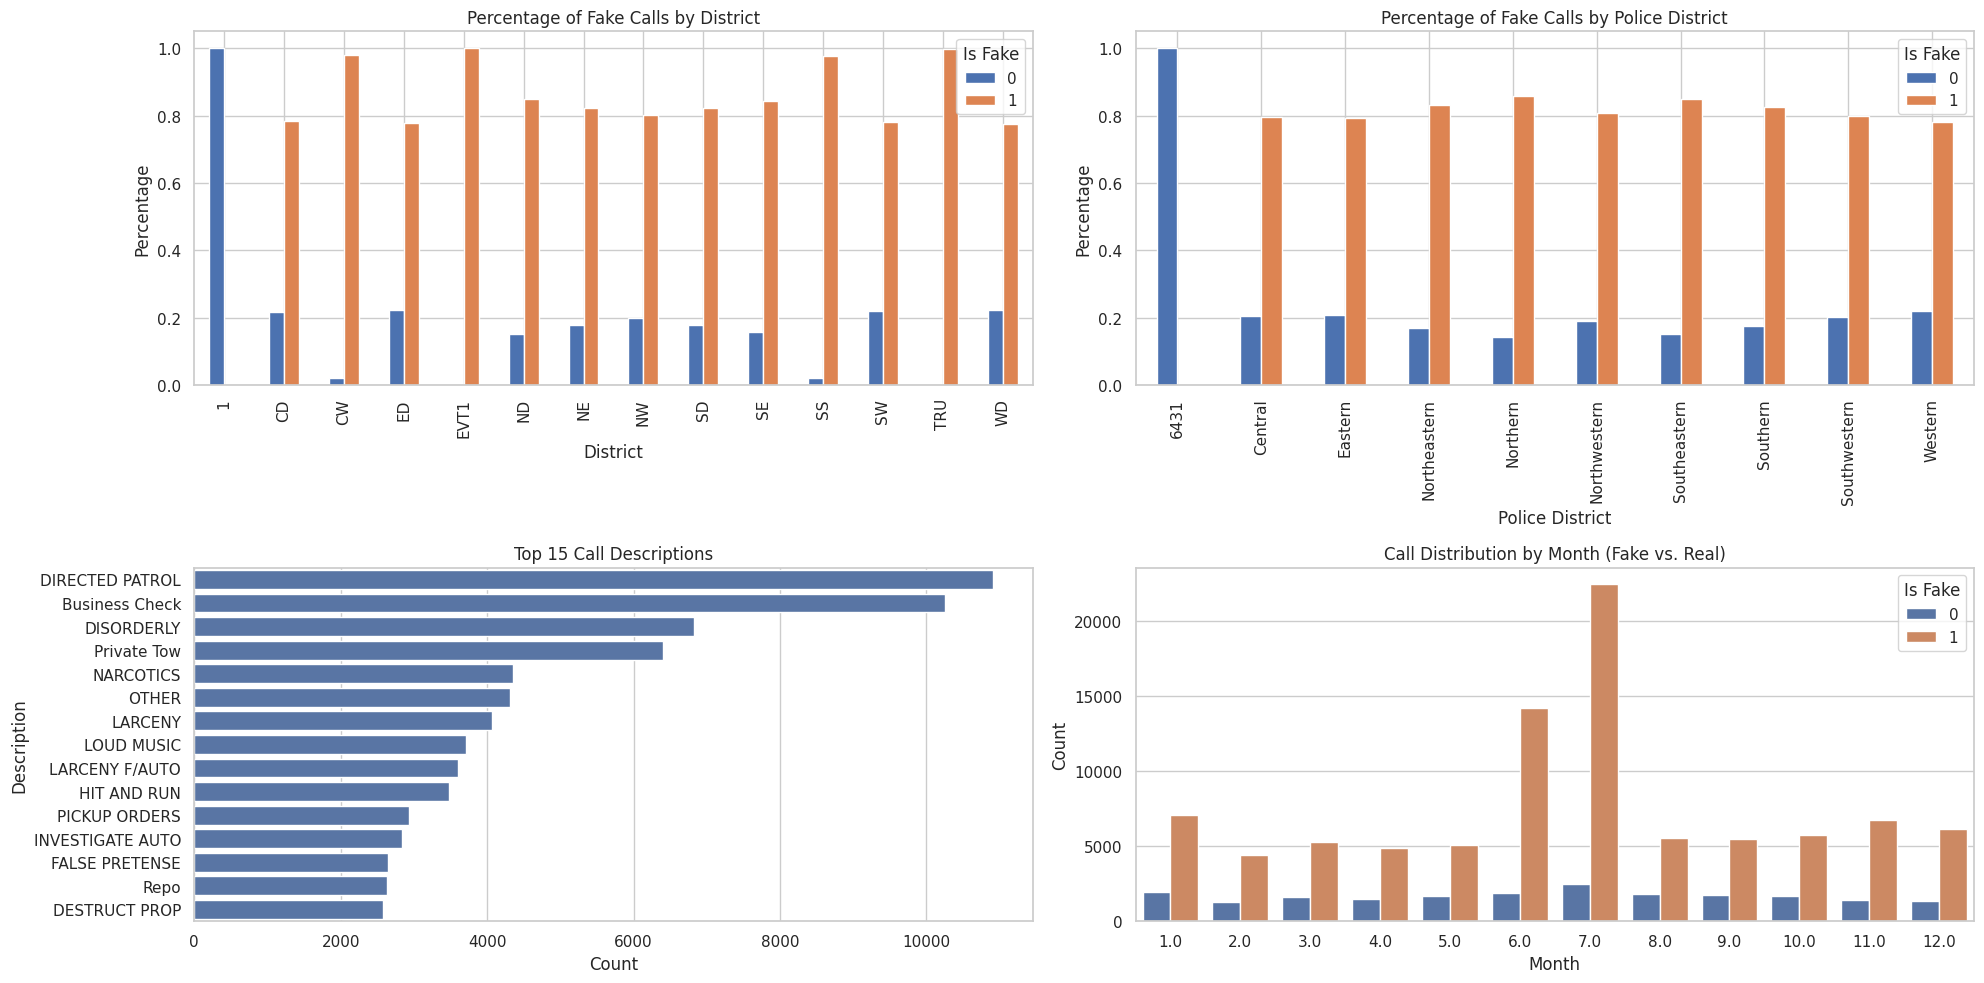

In [ ]:
# Visualize data
data = visualize_data(data)

In [ ]:
# Engineer features
X, y, processed_data = engineer_features(data)


--- Feature Engineering ---
Creating TF-IDF features from description...
Feature engineering completed. Feature shape: (113527, 130)
No NaN values present in features - data is ready for modeling


In [ ]:
# Split data
X_train, X_test, y_train, y_test = split_data(X, y)

Training set shape: (90821, 130)
Testing set shape: (22706, 130)



--- Building Models ---

Training Random Forest...
Random Forest Results:
Accuracy: 0.9813
Precision: 0.9856
Recall: 0.9917
F1 Score: 0.9886

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      4090
           1       0.99      0.99      0.99     18616

    accuracy                           0.98     22706
   macro avg       0.97      0.96      0.97     22706
weighted avg       0.98      0.98      0.98     22706



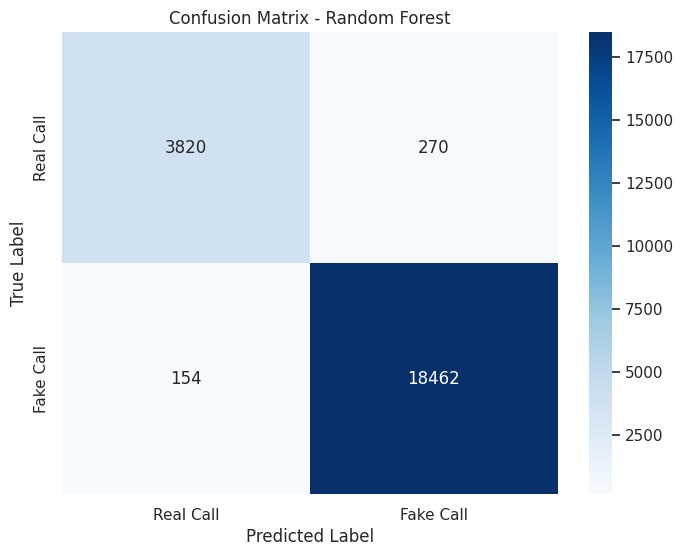


Training Gradient Boosting...
Gradient Boosting Results:
Accuracy: 0.9844
Precision: 0.9871
Recall: 0.9939
F1 Score: 0.9905

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4090
           1       0.99      0.99      0.99     18616

    accuracy                           0.98     22706
   macro avg       0.98      0.97      0.97     22706
weighted avg       0.98      0.98      0.98     22706



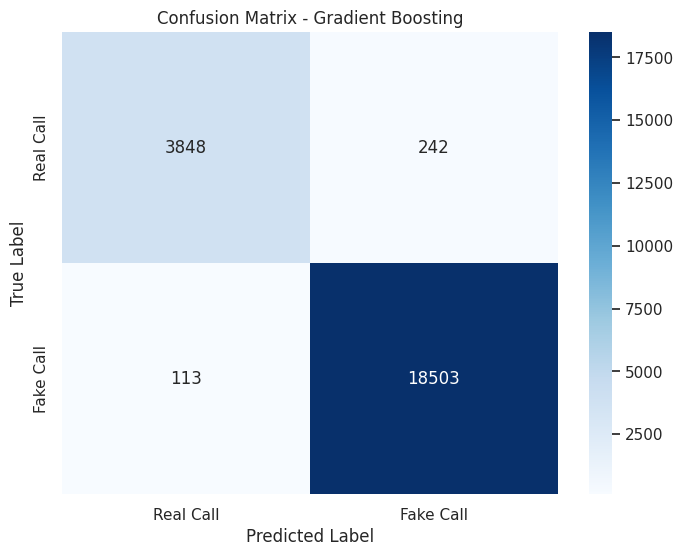


Training Logistic Regression...
Logistic Regression Results:
Accuracy: 0.9843
Precision: 0.9878
Recall: 0.9931
F1 Score: 0.9904

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      4090
           1       0.99      0.99      0.99     18616

    accuracy                           0.98     22706
   macro avg       0.98      0.97      0.97     22706
weighted avg       0.98      0.98      0.98     22706



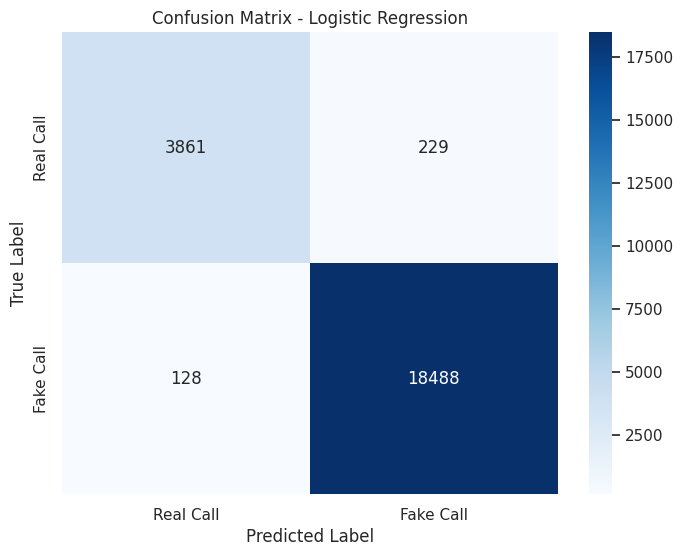


--- Training Decision Tree Model ---
Decision Tree Results:
Accuracy: 0.9498
Precision: 0.9428
Recall: 0.9994
F1 Score: 0.9703

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.72      0.84      4090
           1       0.94      1.00      0.97     18616

    accuracy                           0.95     22706
   macro avg       0.97      0.86      0.90     22706
weighted avg       0.95      0.95      0.95     22706



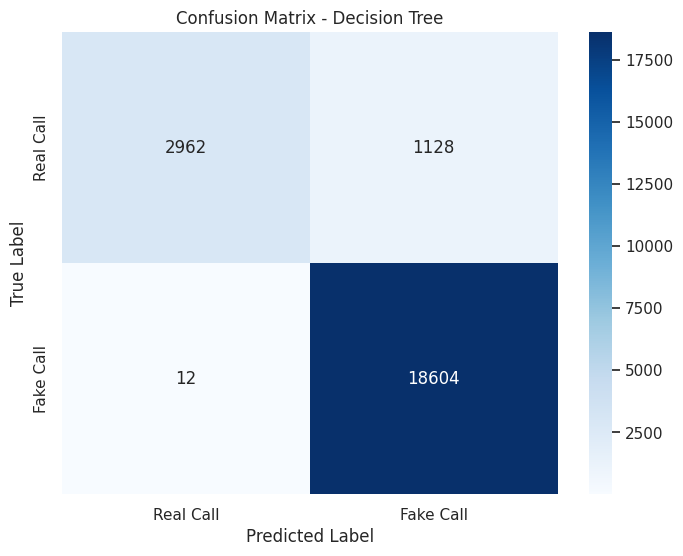

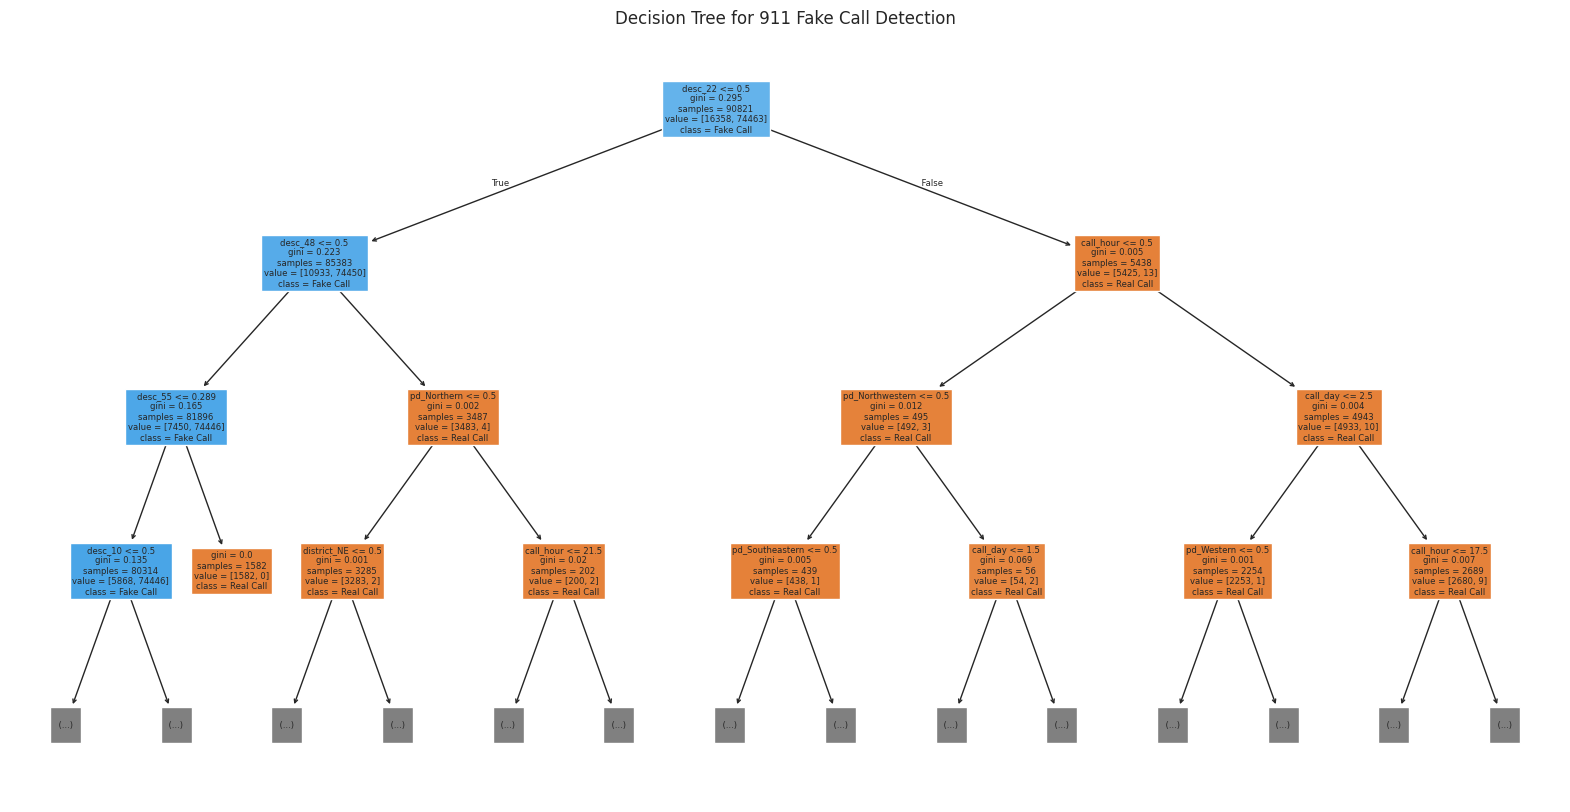


--- Training Artificial Neural Network (ANN) Model ---
Epoch 1/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.9530 - loss: 0.1267 - val_accuracy: 0.9830 - val_loss: 0.0597
Epoch 2/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9835 - loss: 0.0589 - val_accuracy: 0.9814 - val_loss: 0.0593
Epoch 3/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9841 - loss: 0.0538 - val_accuracy: 0.9832 - val_loss: 0.0582
Epoch 4/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9844 - loss: 0.0520 - val_accuracy: 0.9834 - val_loss: 0.0592
Epoch 5/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9846 - loss: 0.0513 - val_accuracy: 0.9825 - val_loss: 0.0570
Epoch 6/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.9840 - loss: 0.0511 - val_accuracy: 0.9813 - val_loss: 0.0587
Epoch 7/50
2271/2271 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9839 - loss: 0.0509 - val_accuracy: 0.9813 - val_loss: 0.0591
Epoch 8/50
2271/2271 ━━━━━━━━━━

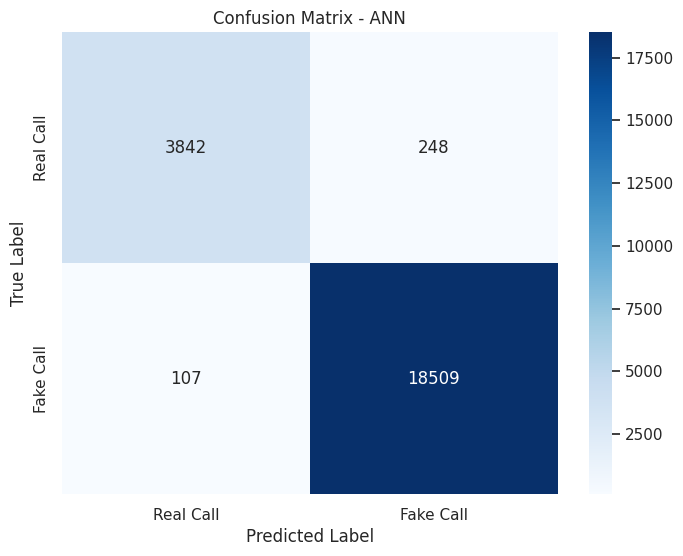

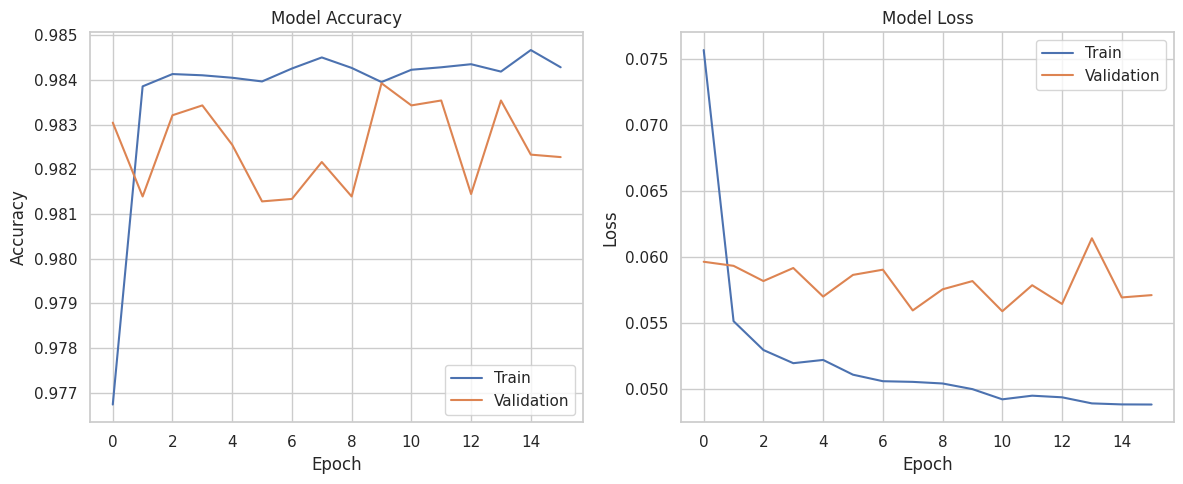

In [ ]:
# Build and evaluate models
model_results = build_models(X_train, X_test, y_train, y_test, data, models_to_train)

In [ ]:
# Find the best model based on F1 score
best_model_name = max(model_results, key=lambda k: model_results[k]['f1_score'])
print(f"\nBest model based on F1 score: {best_model_name}")


Best model based on F1 score: ANN


In [ ]:
# Don't tune ANN or RNN models (they have already been optimized)
if best_model_name not in ['ANN', 'RNN']:
    # Tune the best model
    tuned_model = tune_model(X_train, y_train, best_model_name)

    # Evaluate the tuned model
    final_results = evaluate_final_model(tuned_model, X_test, y_test)

    # Get and visualize feature importance
    feature_importance = get_feature_importance(tuned_model, X_test, y_test)
    visualize_feature_importance(feature_importance, f"Final {best_model_name}")
else:
    print(f"\n{best_model_name} was the best model. No further tuning needed.")
    tuned_model = model_results[best_model_name]['model']



ANN was the best model. No further tuning needed.


In [ ]:
# Interpret TF-IDF features
reverse_vocab = interpret_tfidf_features(data)

Feature desc_22 represents: disorderly
Feature desc_48 represents: narcotics
Feature desc_30 represents: expart
Feature desc_10 represents: burglary
Feature desc_5 represents: assault



--- Analyzing Patterns in Fake Calls ---
Number of fake calls: 93079

1. Most Common Descriptions for Fake Calls:
description
DIRECTED PATROL     10906
Business Check      10260
Private Tow          6226
OTHER                4294
LARCENY              4041
LOUD MUSIC           3713
LARCENY F/AUTO       3602
HIT AND RUN          3483
PICKUP ORDERS        2922
INVESTIGATE AUTO     2839
FALSE PRETENSE       2648
Repo                 2584
DESTRUCT PROP        2580
Foot Patrol          1938
AUTO ACCIDENT        1904
Name: count, dtype: int64


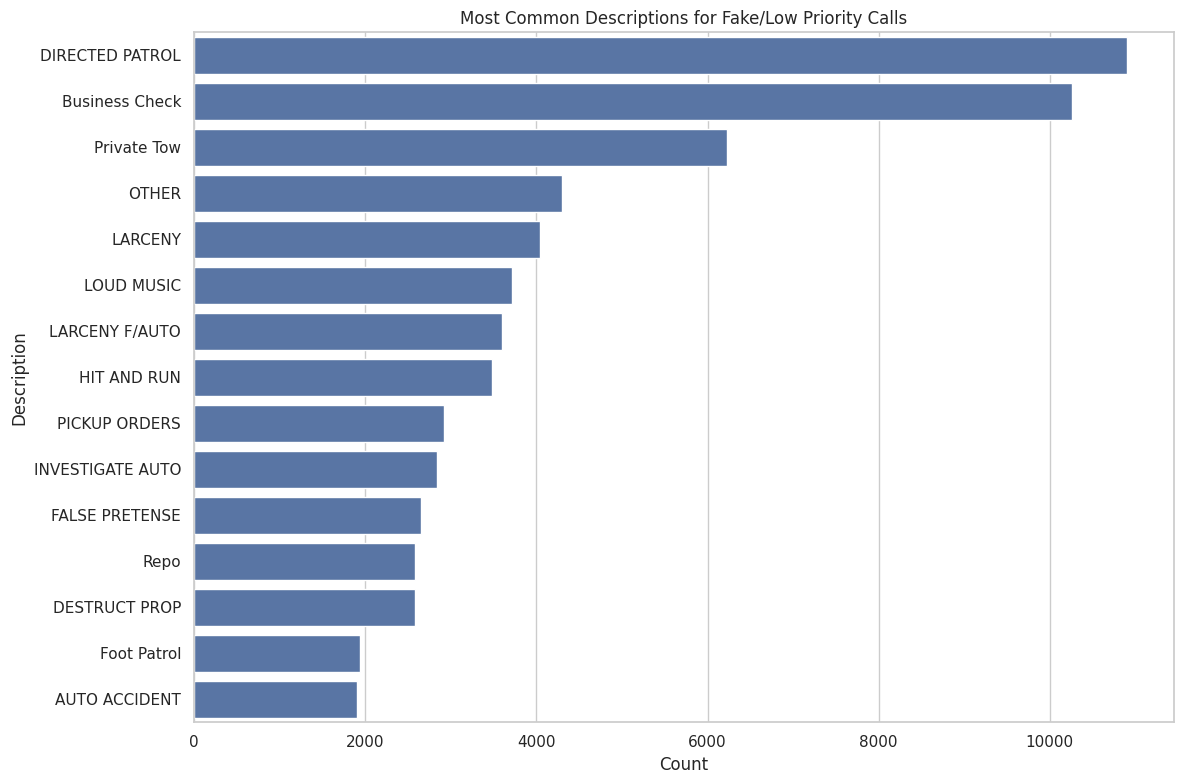


2. Time Patterns for Fake Calls:


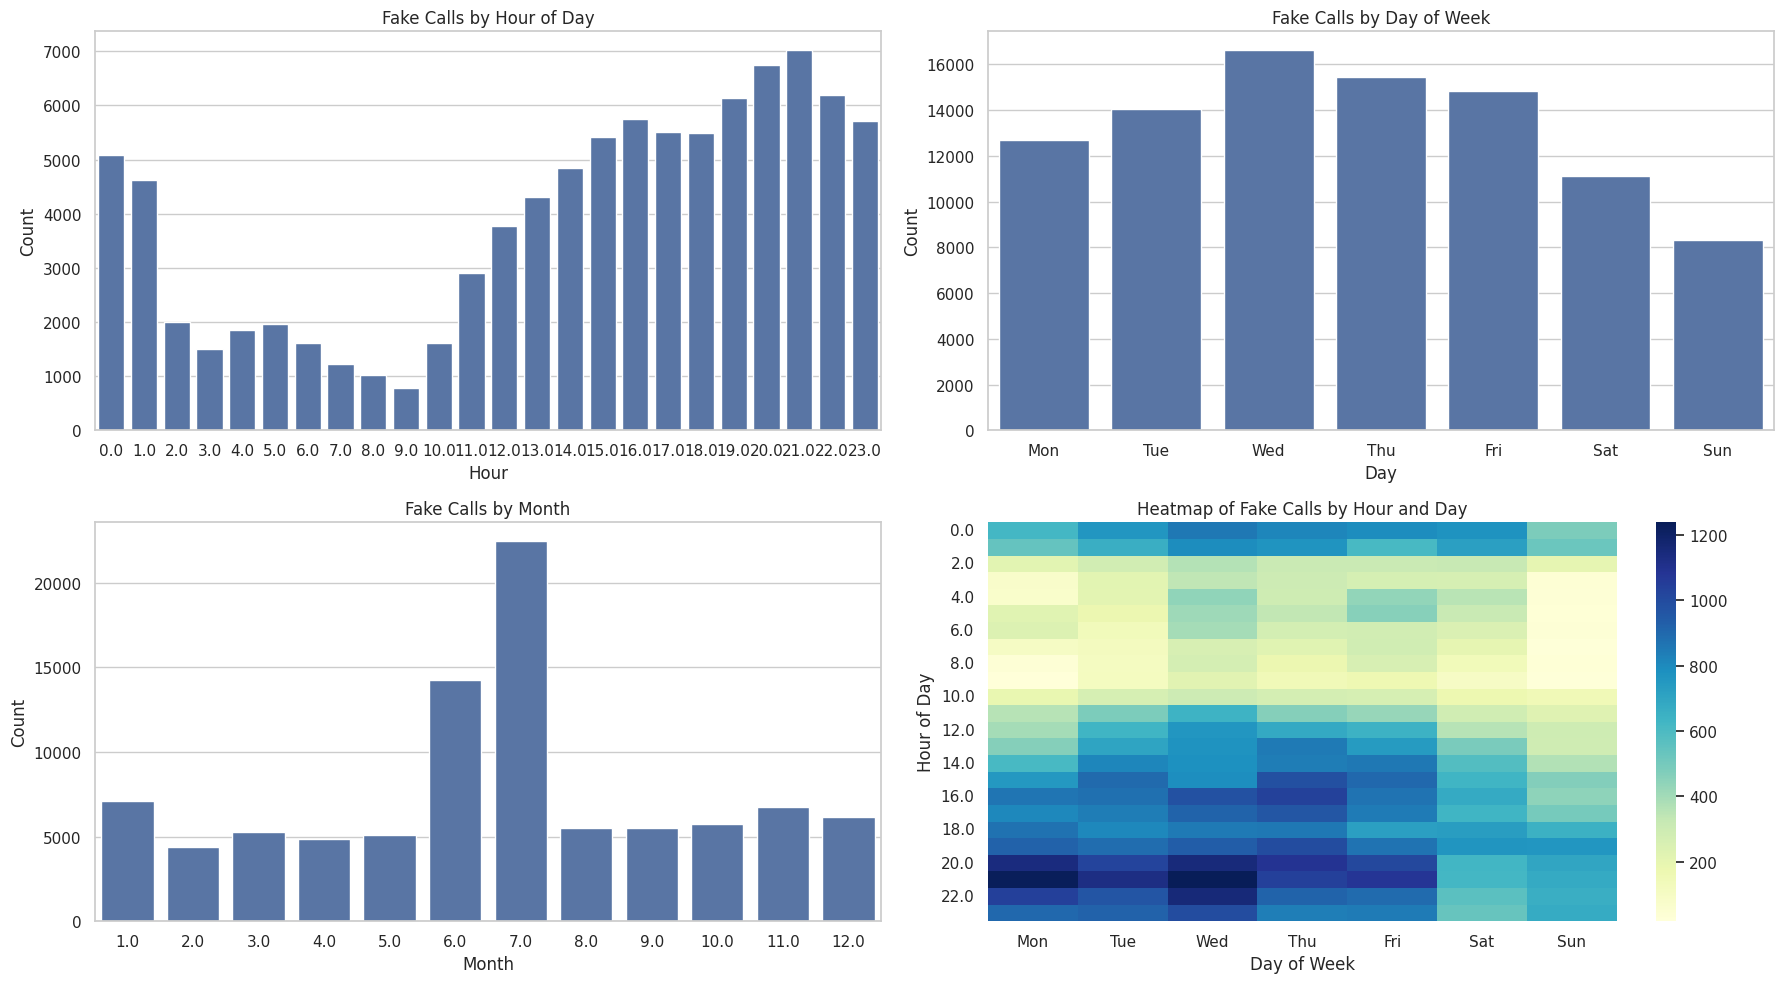


3. Location Patterns for Fake Calls:


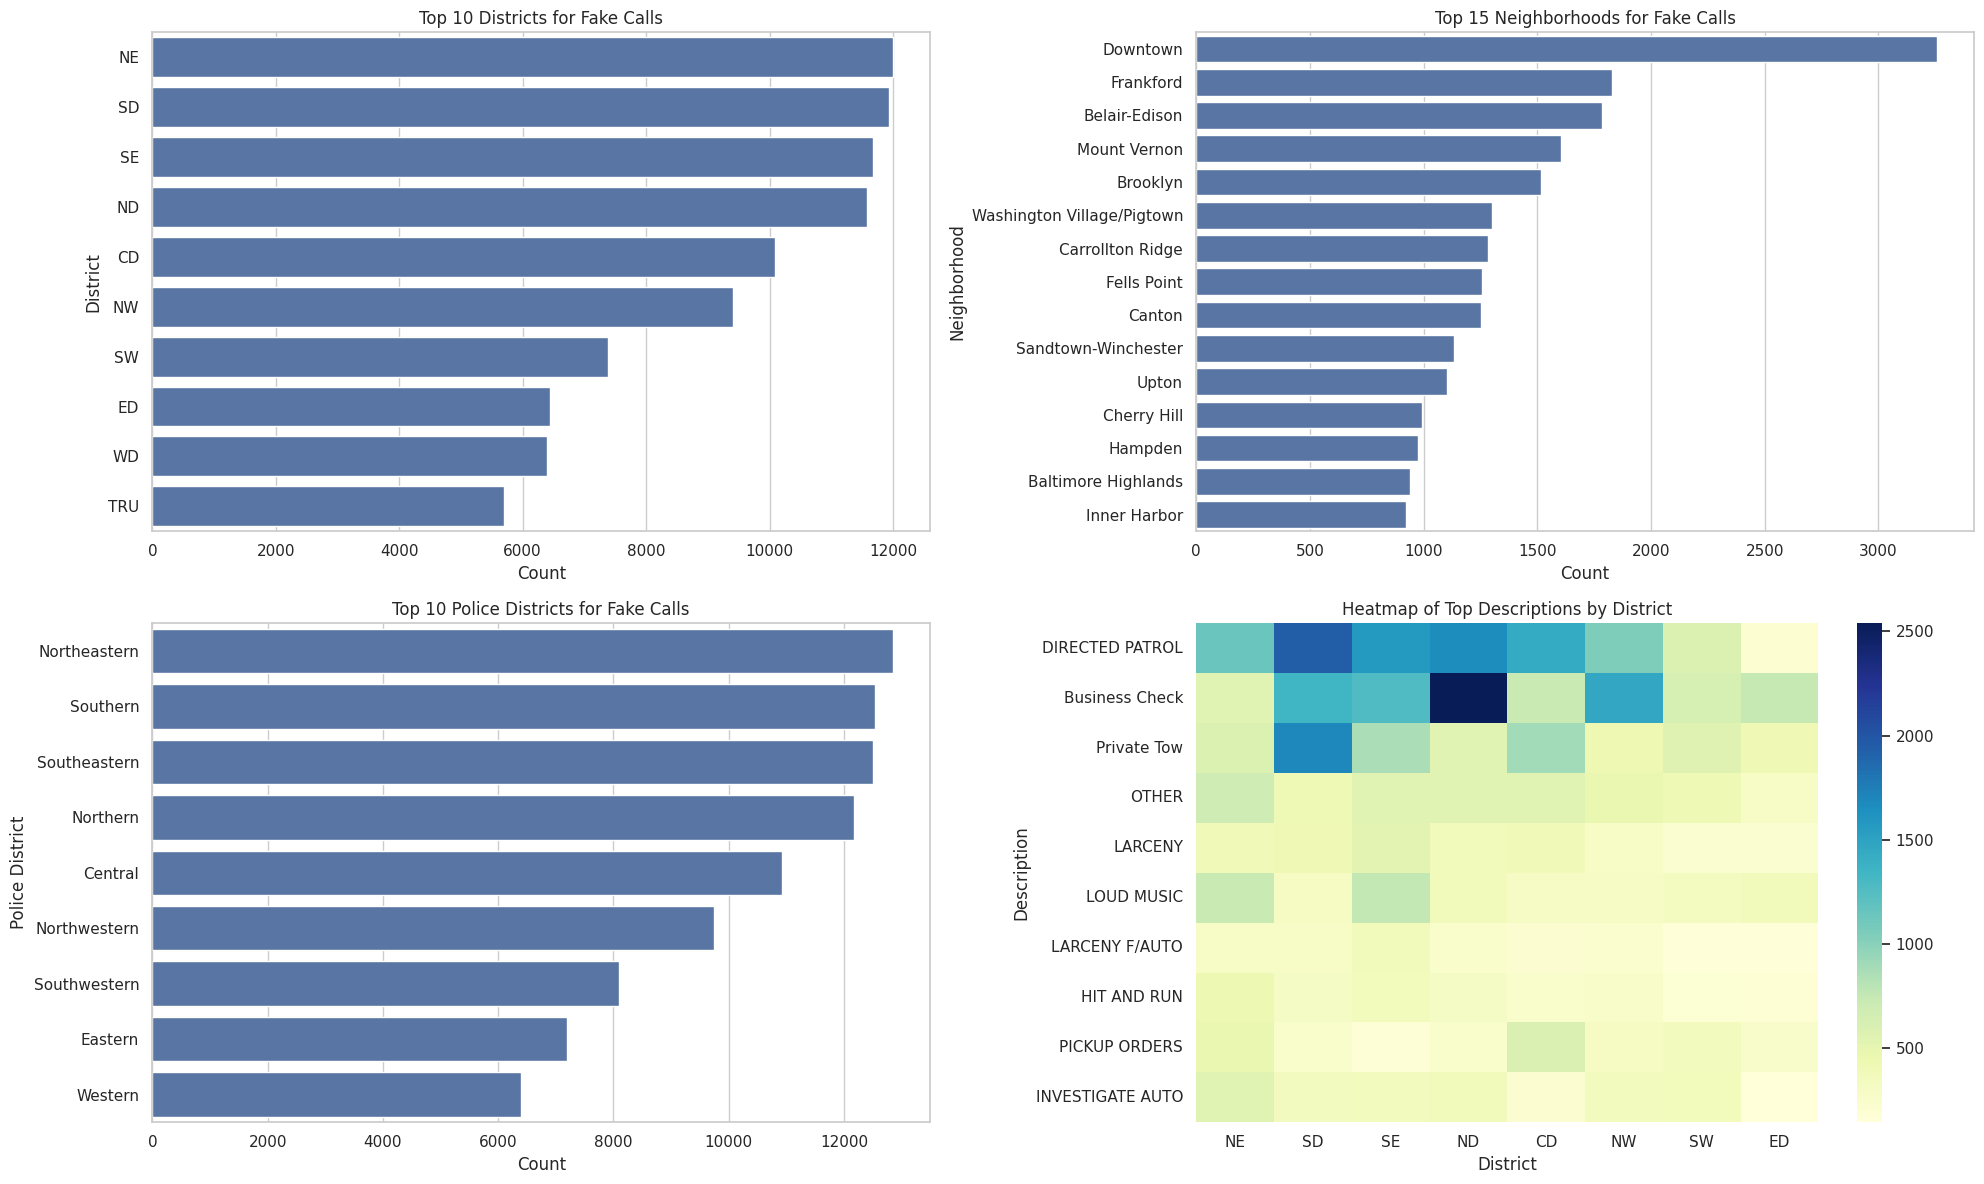


6. Key Patterns in Fake Calls:
a. Most common fake call description: DIRECTED PATROL
b. Peak hour for fake calls: 21.0
c. Peak day for fake calls: Wed
d. Most common location for fake calls: Downtown


In [ ]:
# Analyze patterns in fake calls
fake_call_patterns = analyze_fake_call_patterns(data)

In [ ]:
print("\nModel training and evaluation completed!")
print(model_results, tuned_model, X, y)


Model training and evaluation completed!
{'Random Forest': {'model': RandomForestClassifier(n_jobs=-1, random_state=42), 'accuracy': 0.9813265216242403, 'precision': 0.9855861627162076, 'recall': 0.9917275461968199, 'f1_score': 0.988647317125415, 'predictions': array([1, 0, 1, ..., 1, 0, 1])}, 'Gradient Boosting': {'model': HistGradientBoostingClassifier(random_state=42), 'accuracy': 0.9843653659825596, 'precision': 0.9870898906375033, 'recall': 0.9939299527288354, 'f1_score': 0.9904981130055406, 'predictions': array([1, 0, 1, ..., 1, 0, 1])}, 'Logistic Regression': {'model': LogisticRegression(max_iter=500, random_state=42), 'accuracy': 0.984277283537391, 'precision': 0.9877651333012769, 'recall': 0.9931241942415127, 'f1_score': 0.9904374146197734, 'predictions': array([1, 0, 0, ..., 1, 0, 1])}, 'Decision Tree': {'model': DecisionTreeClassifier(max_depth=5, random_state=42), 'accuracy': 0.9497930062538537, 'precision': 0.9428339752685992, 'recall': 0.9993553932101418, 'f1_score': 0.9

In [ ]:
# Global variable to store the tfidf vectorizer
global_tfidf_vectorizer = None